## US presidential elections model

In [ ]:
# Usual external stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# ML tools
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split

# Internal utils
from Utils import Plot 

## Load and prepare raw data

In [133]:
# Election winners by year
df_ele = pd.read_csv('../Data/ElectionData.csv')
# Filter before 1960 
df_ele = df_ele[df_ele['Year'] >= 1960]
# Reset index
# df_ele.set_index('Year',inplace=True)
# Display
display(df_ele)

,Year,Winner,Party,EC,PV,Lean,Era
0,2024,Donald Trump,Republican,0.4200,0.4834,Right,Populist
1,2020,Joseph Biden,Democratic,0.5688,0.5131,Left,Populist
2,2016,Donald Trump,Republican,0.5690,0.4620,Right,Populist
3,2012,Barack Obama,Democratic,0.6170,0.5110,Left,Partisan Polarisation
4,2008,Barack Obama,Democratic,0.6780,0.5290,Left,Partisan Polarisation
5,2004,George W. Bush,Republican,0.5320,0.5070,Right,Partisan Polarisation
6,2000,George W. Bush,Republican,0.5040,0.4790,Right,Post-Cold War
7,1996,William Clinton,Democratic,0.7040,0.4920,Left,Post-Cold War
8,1992,William Clinton,Democratic,0.6880,0.4300,Left,Post-Cold War
9,1988,George Bush,Republican,0.7920,0.5340,Right,Post-1960s Realignment


In [134]:
# World bank indicators by year https://databank.worldbank.org/indicator/NY.GDP.MKTP.KD.ZG/1ff4a498/Popular-Indicators
df_wbind = pd.read_csv('../Data/WorldBankPopularIndicators_1960-2023.csv')

# Replace .. with NaN 
df_wbind.replace('..', np.nan, inplace=True)
# Drop unneeded columns 
df_wbind = df_wbind.drop(['Series Code', 'Country Name', 'Country Code'], axis=1)
# Rename
df_wbind = df_wbind.rename(columns={'Series Name' : 'Year'})
# Reformat
df_wbind.columns = df_wbind.columns.str.replace(r'\s\[YR\d{4}\]', '', regex=True)

# Transpose
df_wbind = df_wbind.transpose().reset_index()
# Reset the column headers
df_wbind.columns = df_wbind.iloc[0]
# Drop the first row, as it has been set as the header
df_wbind = df_wbind.drop(index=df_wbind.index[0]) 

# For the sake of this exericse, treat 2023 data as 2024 data... 
df_wbind.at[64, 'Year'] = 2024

# Display
display(df_wbind)

,Year,"Population, total",Population growth (annual %),Surface area (sq. km),Poverty headcount ratio at national poverty lines (% of population),"GNI, Atlas method (current US$)","GNI per capita, Atlas method (current US$)","GNI, PPP (current international $)","GNI per capita, PPP (current international $)",Income share held by lowest 20%,...,Net barter terms of trade index (2015 = 100),"External debt stocks, total (DOD, current US$)",Total debt service (% of GNI),Net migration,"Personal remittances, paid (current US$)","Foreign direct investment, net inflows (BoP, current US$)",Net ODA received per capita (current US$),GDP per capita (current US$),"Foreign direct investment, net (BoP, current US$)","Inflation, consumer prices (annual %)"
1,1960,180671000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,422708,NaN,NaN,NaN,2999.864872,NaN,1.457975986
2,1961,183691000,1.657730037,9629090,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,580333,NaN,NaN,NaN,3059.160821,NaN,1.070724148
3,1962,186538000,1.537997358,9629090,NaN,6.07686E+11,3260,NaN,NaN,NaN,...,NaN,NaN,NaN,625617,NaN,NaN,NaN,3236.013112,NaN,1.198773348
4,1963,189242000,1.439164762,9629090,NaN,6.41492E+11,3390,NaN,NaN,5.7,...,NaN,NaN,NaN,639495,NaN,NaN,NaN,3366.36979,NaN,1.239669421
5,1964,191889000,1.389046055,9629090,NaN,6.87248E+11,3580,NaN,NaN,5.7,...,NaN,NaN,NaN,618635,NaN,NaN,NaN,3565.31443,NaN,1.278911565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,2019,328329953,0.455381286,9831510,NaN,2.17421E+13,66220,2.17648E+13,66290,5.2,...,100.3187251,NaN,NaN,1774500,71583000000,3.15984E+11,NaN,65604.68152,-2.01057E+11,1.812210075
61,2020,331526933,0.968999516,9831510,NaN,2.14248E+13,64620,2.14581E+13,64720,5.7,...,100,NaN,NaN,329769,66126000000,1.37066E+11,NaN,64411.37318,1.45265E+11,1.233584396
62,2021,332048977,0.157342694,9831510,NaN,2.37414E+13,71500,2.38322E+13,71770,6.1,...,104.6546547,NaN,NaN,674787,73551000000,4.75805E+11,NaN,71318.30736,-1.33851E+11,4.697858864
63,2022,333271411,0.367472694,9831510,NaN,2.58152E+13,77460,2.62318E+13,78710,5.2,...,NaN,NaN,NaN,1319009,87025000000,4.08982E+11,NaN,78035.17536,-20472000000,8.002799821


In [135]:
# FRED unmployment data https://fred.stlouisfed.org/series/UNRATE
df_emp = pd.read_csv('../Data/FREDUnemploymentRate_1948-01-01_2024-11-01.csv')
# Rename column
df_emp = df_emp.rename(columns={'UNRATE': 'Unemployment'})
# Get year
df_emp['observation_date'] = pd.to_datetime(df_emp['observation_date'], errors='coerce')
df_emp['Year'] = df_emp['observation_date'].dt.year
# Convert to ints
df_wbind['Year'] = df_wbind['Year'].astype(int)
# Get yearly average
df_emp = df_emp.groupby('Year')['Unemployment'].mean().reset_index()
# Filter before 1960 
df_emp = df_emp[df_emp['Year'] >= 1960]
display(df_emp)

,Year,Unemployment
12,1960,5.541667
13,1961,6.691667
14,1962,5.566667
15,1963,5.641667
16,1964,5.158333
...,...,...
72,2020,8.091667
73,2021,5.350000
74,2022,3.633333
75,2023,3.625000


In [136]:
# Merge all DataFrames on the 'Year' column
df_comb = df_ele.merge(df_emp, on='Year').merge(df_wbind, on='Year')

# Filter columns with fewer than 8 non-name unique values
df_comb = df_comb.dropna(axis=1)
# df_comb = df_comb.loc[:, df_comb.notna().sum() >= 8]

# Political binary
df_comb['political_binary'] = df_comb['Lean'].map({'Left': 0, 'Right': 1})

display(df_comb)

df_comb.to_csv('../Data/CombinedData_1960-2020.csv')


,Year,Winner,Party,EC,PV,Lean,Era,Unemployment,"Population, total",GDP (current US$),Merchandise trade (% of GDP),Net migration,GDP per capita (current US$),"Inflation, consumer prices (annual %)",political_binary
0,2024,Donald Trump,Republican,0.4200,0.4834,Right,Populist,4.027273,334914895,2.77207E+13,18.7335829,1322668,82769.41221,4.116338384,1
1,2020,Joseph Biden,Democratic,0.5688,0.5131,Left,Populist,8.091667,331526933,2.13541E+13,17.9444046,329769,64411.37318,1.233584396,0
2,2016,Donald Trump,Republican,0.5690,0.4620,Right,Populist,4.875000,323071755,1.88049E+13,19.6819044,1889129,58206.61419,1.261583206,1
3,2012,Barack Obama,Democratic,0.6170,0.5110,Left,Partisan Polarisation,8.075000,313877662,1.6254E+13,23.88479245,1632007,51784.41147,2.069337265,0
4,2008,Barack Obama,Democratic,0.6780,0.5290,Left,Partisan Polarisation,5.800000,304093966,1.47699E+13,23.40528977,1416841,48570.05943,3.839100297,0
5,2004,George W. Bush,Republican,0.5320,0.5070,Right,Partisan Polarisation,5.541667,292805298,1.22172E+13,19.15787387,1313467,41724.6412,2.677236693,1
6,2000,George W. Bush,Republican,0.5040,0.4790,Right,Post-Cold War,3.966667,282162411,1.0251E+13,19.91247252,1248392,36329.97026,3.376857271,1
7,1996,William Clinton,Democratic,0.7040,0.4920,Left,Post-Cold War,5.408333,269394000,8.07312E+12,17.92488705,1141648,29967.71272,2.9312042,0
8,1992,William Clinton,Democratic,0.6880,0.4300,Left,Post-Cold War,7.491667,256514000,6.52033E+12,15.36864639,1304880,25418.99078,3.028819678,0
9,1988,George Bush,Republican,0.7920,0.5340,Right,Post-1960s Realignment,5.491667,244499000,5.23644E+12,14.93324279,460778,21417.01193,4.077741107,1


## Extract features and prepare data

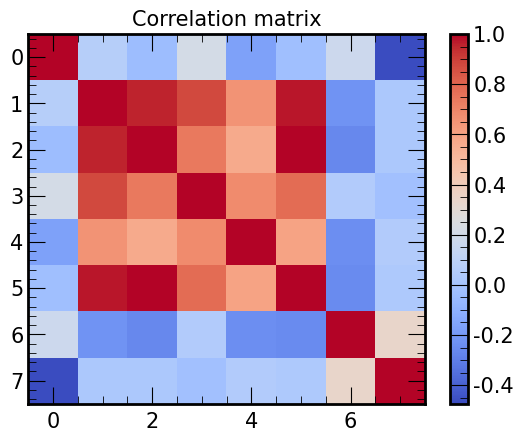

,Feature,Correlation with Political Binary
0,political_binary,1.000000
1,"Inflation, consumer prices (annual %)",0.333160
2,Net migration,0.053432
3,GDP per capita (current US$),0.038160
4,GDP (current US$),0.031174
5,"Population, total",0.030020
6,Merchandise trade (% of GDP),-0.016457
7,Unemployment,-0.473636


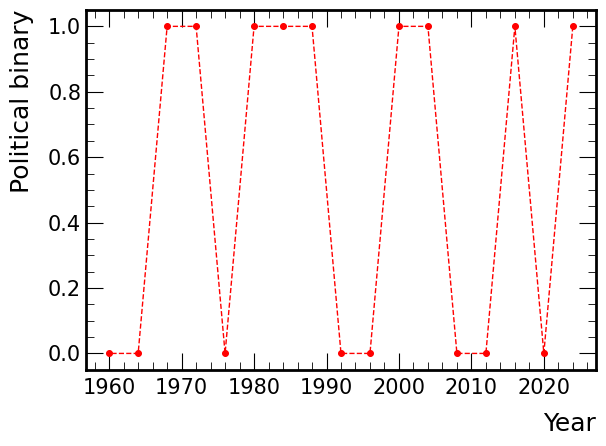

,Year,"Inflation, consumer prices (annual %)",Unemployment,political_binary
0,2024,4.116338,4.027273,1
1,2020,1.233584,8.091667,0
2,2016,1.261583,4.875000,1
3,2012,2.069337,8.075000,0
4,2008,3.839100,5.800000,0
5,2004,2.677237,5.541667,1
6,2000,3.376857,3.966667,1
7,1996,2.931204,5.408333,0
8,1992,3.028820,7.491667,0
9,1988,4.077741,5.491667,1


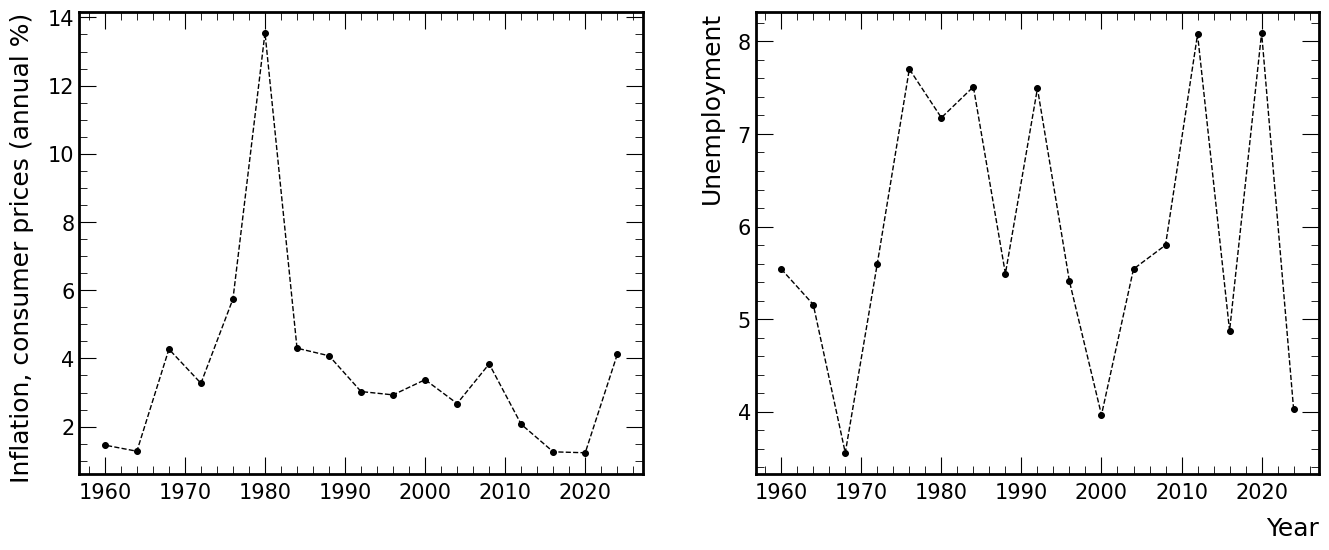

In [137]:
def prepare_data(df_in): 

    # Extract correlations 

    # List of columns to exclude
    exclude_columns = ['Year', 'Winner', 'Party', 'EC', 'PV', 'Lean', 'Era']

    # Filter the dataframe to exclude specific columns
    df_corr = df_in.drop(columns=exclude_columns)

    # Calculate the correlation matrix
    corr_matrix = df_corr.corr()

    # Plot the heatmap using imshow
    plt.figure()
    plt.imshow(corr_matrix, cmap='coolwarm', aspect='auto')
    plt.colorbar()

    plt.title("Correlation matrix")
    plt.show()

    # Extract the correlation with 'political_binary'
    corr_with_target = corr_matrix['political_binary'].sort_values(ascending=False)
    # Convert the correlation series to a DataFrame
    corr_with_target = corr_with_target.to_frame().reset_index()
    # Set columns
    corr_with_target.columns = ['Feature', 'Correlation with Political Binary']
    # Drop NaN values
    corr_with_target = corr_with_target.dropna()

    # Display he correlations for the features with political_binary
    display(corr_with_target)

    # Get features with correlation over 30% 
    features = corr_with_target['Feature'][np.abs(corr_with_target['Correlation with Political Binary']) >= 0.30]
    # Drop political_binary from features
    features = features.drop(index=0)
    
    # Create model data
    df_model = df_in[['Year'] + list(features) + ['political_binary']].dropna()
    
    # Plot features over time
    pl = Plot()

    # Plot poltical binary
    pl.plot_graph(x=df_model['Year'], y=df_model['political_binary'],
                xlabel='Year', ylabel='Political binary',
                linestyle="--", col='red', save=False)

    # Plot features
    fig, ax1 = plt.subplots(1,2, figsize=(8*2, 6)) 

    # Fix non-numeric values
    for i_feature, feature in enumerate(features):

        df_model[feature] = pd.to_numeric(df_model[feature], errors='coerce')

        # row, col = divmod(i_feature, 2)  # Calculate the row and column index for ax1

        pl.plot_graph(x=df_model['Year'], y=list(df_model[feature]),
                xlabel='Year', ylabel=feature,
                linestyle="--", save=False, ax=ax1[i_feature]) # row, col])
        
        # Explicitly set the axes labels
        # ax1[row, col].set_xlabel('Year')
        # ax1[row, col].set_ylabel(feature)
        ax1[i_feature].set_ylabel(feature)

    return df_model, features

df_model, features = prepare_data(df_comb)

display(df_model)

# Define features and target for modelling
X = df_model[features]
y = df_model['political_binary']

## Baseline logitistic regression

In [138]:
def train_model(X, y, random_state=42):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_state
    )
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train the model
    model = LogisticRegression(random_state=random_state)
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Get feature importance
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': abs(model.coef_[0])
    }).sort_values('Importance', ascending=False)
    
    return model, accuracy, feature_importance, scaler

model, accuracy, importance, scaler = train_model(X, y, random_state=42)

print('Model:', model)
print('Accuracy:', accuracy)
print('Importance:\n', importance)

Model: LogisticRegression(random_state=42)
Accuracy: 0.75
Importance:
                                  Feature  Importance
1                           Unemployment    0.867527
0  Inflation, consumer prices (annual %)    0.679403


## Logisitic regression with leave-one-out cross validation (LOOCV)

In [139]:
def train_model(X, y, random_state=42):
    # Initialise the Leave-One-Out cross-validation
    loo = LeaveOneOut()
    
    accuracies = []
    feature_importances = []
    
    # Loop through each train-test split from LOO
    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Scale the features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train the model
        model = LogisticRegression(random_state=random_state)
        model.fit(X_train_scaled, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test_scaled)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
        
        # Get feature importance for this iteration
        importance = pd.DataFrame({
            'Feature': X.columns,
            'Importance': abs(model.coef_[0])
        }).sort_values('Importance', ascending=False)
        
        feature_importances.append(importance)
    
    # Average the accuracy across all splits
    avg_accuracy = np.mean(accuracies)
    
    # Aggregate feature importances
    all_feature_importances = pd.concat(feature_importances).groupby('Feature').mean().sort_values('Importance', ascending=False)
    
    return model, avg_accuracy, all_feature_importances, scaler

model, avg_accuracy, importance, scaler = train_model(X, y) 

print('Model:', model)
print('Average Accuracy:', avg_accuracy)
print('Feature Importance:\n', importance)


Model: LogisticRegression(random_state=42)
Average Accuracy: 0.5882352941176471
Feature Importance:
                                        Importance
Feature                                          
Unemployment                             0.976647
Inflation, consumer prices (annual %)    0.797309


## Random forest with LOOCV

In [140]:
def train_model(X, y, random_state=42):
    loo = LeaveOneOut()
    accuracies = []
    feature_importances = []
    
    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Scale the features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train the model
        model = RandomForestClassifier(random_state=random_state)
        model.fit(X_train_scaled, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test_scaled)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
        
        # Get feature importance for this iteration
        importance = pd.DataFrame({
            'Feature': X.columns,
            'Importance': model.feature_importances_
        }).sort_values('Importance', ascending=False)
        
        feature_importances.append(importance)
    
    avg_accuracy = np.mean(accuracies)
    all_feature_importances = pd.concat(feature_importances).groupby('Feature').mean().sort_values('Importance', ascending=False)
    
    return model, avg_accuracy, all_feature_importances, scaler

model, avg_accuracy, importance, scaler = train_model(X, y)

print('Model:', model)
print('Average Accuracy:', avg_accuracy)
print('Feature Importance:\n', importance)


Model: RandomForestClassifier(random_state=42)
Average Accuracy: 0.5882352941176471
Feature Importance:
                                        Importance
Feature                                          
Unemployment                             0.501291
Inflation, consumer prices (annual %)    0.498709


## SVM with LOOCV

In [141]:
def train_model(X, y, random_state=42):
    loo = LeaveOneOut()
    accuracies = []
    feature_importances = []
    
    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Scale the features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train the model (using SVM)
        # model = SVC(random_state=random_state)
        # model.fit(X_train_scaled, y_train)

        # Train the model (using linear SVM)
        model = SVC(kernel='linear', random_state=random_state)
        model.fit(X_train_scaled, y_train)

        
        # Make predictions
        y_pred = model.predict(X_test_scaled)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
        
        # SVM doesn't have feature importances directly, so we'll use coefficients
        importance = pd.DataFrame({
            'Feature': X.columns,
            'Importance': np.abs(model.coef_[0])  # Taking absolute values of the coefficients
        }).sort_values('Importance', ascending=False)
        
        feature_importances.append(importance)
    
    avg_accuracy = np.mean(accuracies)
    all_feature_importances = pd.concat(feature_importances).groupby('Feature').mean().sort_values('Importance', ascending=False)
    
    return model, avg_accuracy, all_feature_importances, scaler

model, avg_accuracy, importance, scaler = train_model(X, y)

print('Model:', model)
print('Average Accuracy:', avg_accuracy)
print('Feature Importance:\n', importance)


Model: SVC(kernel='linear', random_state=42)
Average Accuracy: 0.47058823529411764
Feature Importance:
                                        Importance
Feature                                          
Unemployment                             0.922941
Inflation, consumer prices (annual %)    0.555398
